# Applicant Shortlisting using Python and Natural Language Processing.
### (Task for Summer Internship at Global Governance Initiative). 

Step # 1: Installing the PyPDF2 package for reading resumes in the PDF format.

In [ ]:
pip install PyPDF2

Step # 2: Importing the necessary libraries.

In [5]:
import math
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import spacy
import en_core_web_sm

Step # 3: Specifying the path where the candidates' resumes are stored in the database. The 'pdfextract' function extracts the resumes and extracts the text, while counting the pages. 

In [6]:
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import PhraseMatcher

# Function to read resumes from the folder in a sequence
path = '/content/Data/Resumes'
can_files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file, 'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:
        pageObj = fileReader.getPage(count)
        count += 1
        t = pageObj.extractText()
        text.append(t)
    return text

Step # 4: The code below performs phrase matching and builds the profile of a candidate by matching the keywords particular to the data science role. In the database, we have a curated a csv file with keywords associated with specialization and skills required by a data scientist. 

In [7]:
def create_profile(file, id):
    text = pdfextract(file)
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    # creating a dictionary of keywords from the csv file
    keyword_dict = pd.read_csv('/content/Data/keywords.csv', encoding='latin-1')
    stats_words = [nlp(text) for text in keyword_dict['statistics'].dropna(axis=0)]
    NLP_words = [nlp(text) for text in keyword_dict['nlp'].dropna(axis=0)]
    ML_words = [nlp(text) for text in keyword_dict['machine learning'].dropna(axis=0)]
    DL_words = [nlp(text) for text in keyword_dict['deep learning'].dropna(axis=0)]
    R_words = [nlp(text) for text in keyword_dict['r programming'].dropna(axis=0)]
    python_words = [nlp(text) for text in keyword_dict['python'].dropna(axis=0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['data engineering'].dropna(axis=0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)

    d = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]
        span = doc[start: end]
        d.append((rule_id, span.text))
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i, j in Counter(d).items())

    df = pd.read_csv(StringIO(keywords), names=['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ', 1).tolist(), columns=['Subject', 'Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(', 1).tolist(), columns=['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'], df2['Keyword'], df2['Count']], axis=1)
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]

    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2), names=['Candidate Name'])

    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis=1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace=True)
    
    ## Calculating Scroing of Candidate :

    tot_sum = df3['Count'].sum();
    score.append((dataf['Candidate Name'][0], tot_sum));

    return dataf

Step # 5: Now, we would map the skill data with the specific candidates and score them on the basis of the matching keywords. These scores would be segregreated on the basis of the specializations. 

In [8]:
data_map = dict();

def data_dict():
    global data_map;

    data_map["DE"] = 4;
    data_map["DL"] = 10;
    data_map["ML"] = 9;
    data_map["NLP"] = 10;
    data_map["Python"] = 5;
    data_map["R"] = 5;
    data_map["Stats"] = 8;


def score_calc():
    global score, final_database2, data_map;
    mm = []
    col = [];
    for i in final_database2.columns:
        col.append(i);

    name = "";
    for i in range(len(final_database2)):
        name = final_database2.iloc[i, 0];
        subsum = 0;
        for j in range(1, len(final_database2.columns)):
            num1 = final_database2.iloc[i, j];
            num2 = data_map.get(col[j]);
            subsum += int(num1) * num2;

        mm.append((name, subsum));

    score = mm;

def Sort_Tuple(tup):
    lst = len(tup)
    for i in range(0, lst):

        for j in range(0, lst - i - 1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup

Step # 6: PrettyTable's main goal is to let you print tables in an attractive ASCII form. We shall use it to display scores and shortlisted candidate in the main function. 

In [9]:
from prettytable import PrettyTable
def Sel_printer(show):
    global score, selected;
    num_sel = math.ceil(len(score) / show);
    selected = [];

    Sort_Tuple(score);

    j = len(score) - 1;
    while (j > 0 and num_sel > 0):
        selected.append((score[j][0], score[j][1]));
        num_sel -= 1;
        j -= 1;

    t = PrettyTable(['Name', 'Score'])
    for i in range(len(selected)):
        t.add_row([selected[i][0], selected[i][1]])

    print(t)

Step # 7: Following is the code to count words under each category and visulaize it through matplotlib. The plot we have created shows a candidates score in terms of the specialization. Such a plot would be useful in determining whether a candidate has core focus on a specialization or has a mix-bag of skills. 

In [20]:
def data_plot():
    global final_database2;
    final_database2 = final_database['Keyword'].groupby(
        [final_database['Candidate Name'], final_database['Subject']]).count().unstack()
    final_database2.reset_index(inplace=True)
    final_database2.fillna(0, inplace=True)
    new_data = final_database2.iloc[:, 1:]
    new_data.index = final_database2['Candidate Name']
    import matplotlib.pyplot as plt

    plt.rcParams.update({'font.size': 10})
    ax = new_data.plot.barh(title="Candidate skill division", legend=False, figsize=(20, 7), stacked=True)
    labels = []
    for j in new_data.columns:
        for i in new_data.index:
            label = str(j) + ": " + str(new_data.loc[i][j])
            labels.append(label)
    patches = ax.patches
    for label, rect in zip(labels, patches):
        width = rect.get_width()
        if width > 0:
            x = rect.get_x()
            y = rect.get_y()
            height = rect.get_height()
            ax.text(x + width / 2., y + height / 2., label, ha='center', va='center')
    plt.show()

Step # 8: In this final step, we convert the candidate database to a more user-friendly dataframe format. In the main function, the resumes of candidates are read in a sequence and the candidate profile function in invoked which builds the candidate profile and the score information is then appended into the final database. 

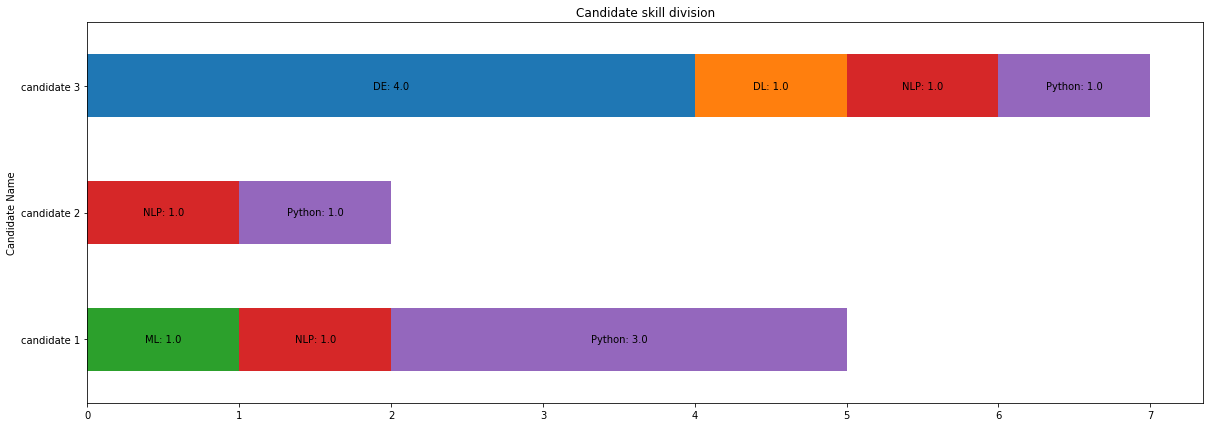


 Subject Candidate Name   DE   DL   ML  NLP  Python  Total Score
0          candidate 1  0.0  0.0  1.0  1.0     3.0          5.0
1          candidate 2  0.0  0.0  0.0  1.0     1.0          2.0
2          candidate 3  4.0  1.0  0.0  1.0     1.0          7.0

Top two shortlisted candidates: 
+-------------+-------+
|     Name    | Score |
+-------------+-------+
| candidate 3 |   41  |
| candidate 1 |   34  |
+-------------+-------+

Selected Candidate:
+-------------+-------+
|     Name    | Score |
+-------------+-------+
| candidate 3 |   41  |
+-------------+-------+


In [28]:
final_database = pd.DataFrame()
final_database2 = pd.DataFrame()
score = []
selected = []

def main():
    global final_database, final_database2, data_map;

    i = 0;
    while i < len(can_files):
        file = can_files[i]
        dat = create_profile(file, i)
        final_database = final_database.append(dat)
        i += 1
        
    
    data_dict()
    data_plot()
    score_calc()
    final_database2.loc[:,'Total Score'] = final_database2.sum(numeric_only=True, axis=1)
    print("\n",final_database2)
    print("\nTop two shortlisted candidates: ")
    Sel_printer(1)
    print("\nSelected Candidate:")
    Sel_printer(10)

if __name__ == '__main__':
    main()